In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline
import sys
sys.path.append('./')

from intersections_and_roads import *
from search import *
from shapely.geometry import *
import ast

In [2]:
bike_accidents = pd.read_csv('./exploration/bicycle_crashes.csv')
bike_crashes_per_street = bike_accidents.groupby(['Street_ID'], as_index=False).size().reset_index()
bike_crashes_per_street.rename(index=str, inplace=True, columns={0: 'num_accidents'})

cb_elevation = pd.read_csv('./cambridgegis_data_trans/node_elevation_cambridge.csv', delimiter=' ', header=None, names=['id', 'elevation'])

intersections = gpd.read_file('./cambridgegis_data_trans/Intersections/TRANS_Intersections.topojson')
street_centerline = gpd.read_file('./cambridgegis_data_trans/Street_Centerlines/TRANS_Centerlines.topojson')
intersection_graph, connection_dict = build_intersection_graph(intersections=intersections, street_centerline=street_centerline, elevation=cb_elevation, accidents=bike_crashes_per_street)

In [3]:
p1 = intersection_graph['1183']
p2 = intersection_graph['1637']
p3 = intersection_graph['20']
p4 = intersection_graph['890']
points = [p1,p2,p3,p4]
to_plot = intersection_graph.copy()
for i in points:
    del to_plot[i.id]

769 <Node> id: 769, x: -71.103299679, y: 42.357441175 
Connections: set([u'Albany_St_1', u'Erie_St_1'])


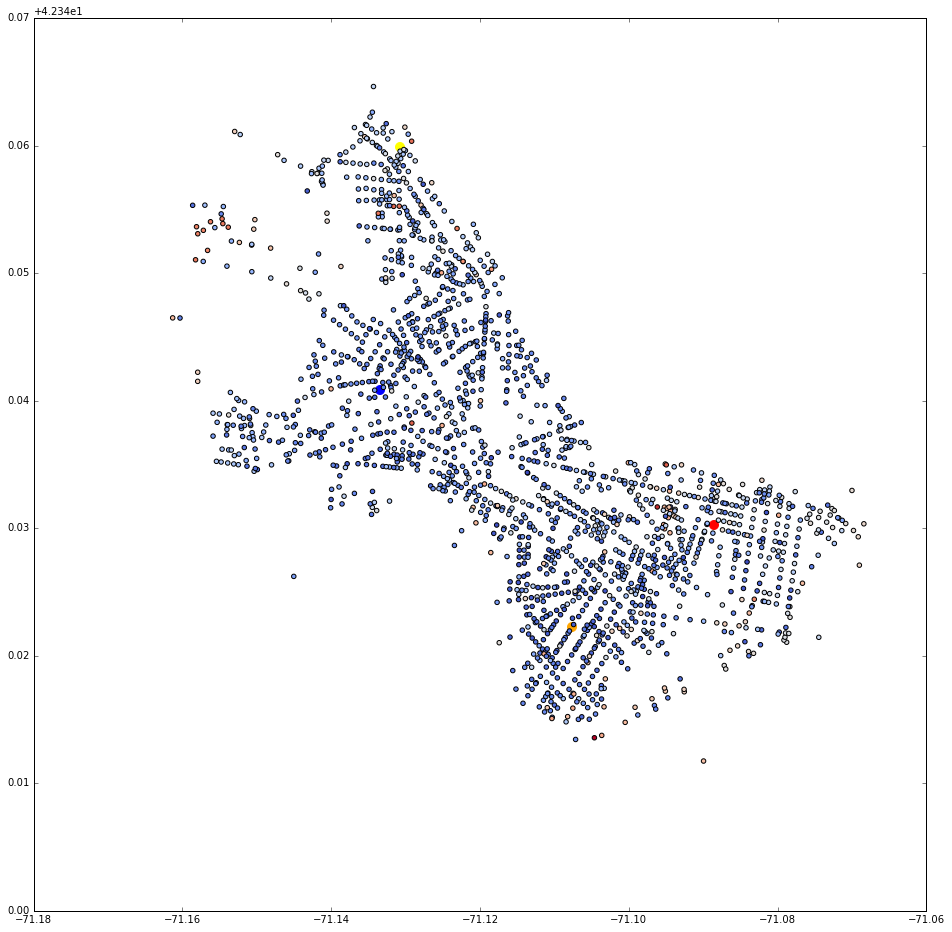

In [4]:
import matplotlib.colors
import matplotlib.cm

fig, ax = plt.subplots(1,1, figsize=(16,16))

ax.scatter(p1.get_x_y()[0], p1.get_x_y()[1], s=80, color='red')
ax.scatter(p2.get_x_y()[0], p2.get_x_y()[1], s=80, color='orange')
ax.scatter(p3.get_x_y()[0], p3.get_x_y()[1], s=80, color='yellow')
ax.scatter(p4.get_x_y()[0], p4.get_x_y()[1], s=80, color='blue')

x_s = []
y_s = []
colours = []
for key, node in to_plot.iteritems():
    try:
        x_s.append(node.get_x_y()[0])
        y_s.append(node.get_x_y()[1])
        c = np.sum([cost(p, node, intersection_graph, connection_dict, get_safe_road_cost_with_elevation, euclidean_heuristic) for p in points])
        colours.append(c)
    except:
        print key, node

        
colors = plt.cm.coolwarm(np.divide(colours-np.min(colours), np.max(colours-np.min(colours))))
ax.scatter(x_s, y_s, c=colors)
plt.show()

(array([  74.,  260.,  515.,  269.,  301.,  208.,  115.,   56.,   23.,    5.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

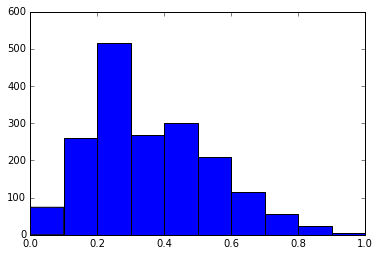

In [9]:
c = np.log(colours)
c = c-np.min(c)
c = c/np.max(c)
plt.hist(c)

In [13]:
centroid = simulated_annealing_b(intersection_graph,
                                 connection_dict,
                                 get_safe_road_cost_with_elevation,
                                 null_heuristic,
                                 starting_points=[p1,p2,p3,p4])

In [21]:
routes = []
for p in points:
    safe_route = a_star_search(p, centroid, intersection_graph, connection_dict, get_safe_road_cost_with_elevation)
    routes.append(safe_route['nodes'])

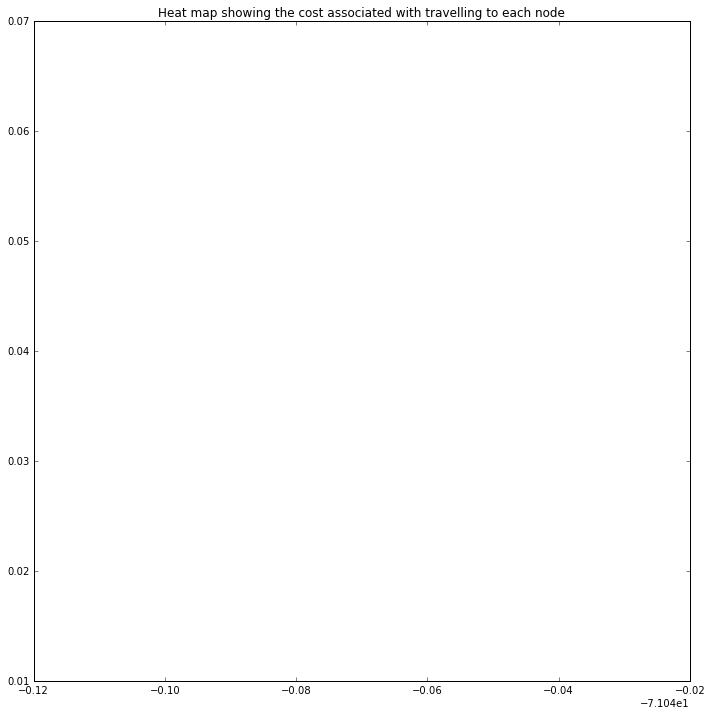

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

colors = plt.cm.YlOrRd(c)
ax.scatter(x_s, y_s, c=colors, linewidths=0, s=25)

ax.scatter(p1.get_x_y()[0], p1.get_x_y()[1], s=80, color='blue')
ax.scatter(p2.get_x_y()[0], p2.get_x_y()[1], s=80, color='blue')
ax.scatter(p3.get_x_y()[0], p3.get_x_y()[1], s=80, color='blue')
ax.scatter(p4.get_x_y()[0], p4.get_x_y()[1], s=80, color='blue')

for route in routes:
    xs = [intersection_graph[node].get_x_y()[0] for node in route]
    ys = [intersection_graph[node].get_x_y()[1] for node in route]
    ax.plot(xs, ys, linewidth=2, color='b')

# mark the simulated annealing centroid
ax.scatter(centroid.get_x_y()[0], centroid.get_x_y()[1], s=120, marker='D', color='green')

ax.set_title('Heat map showing the cost associated with travelling to each node')

ax.set_xlim([-71.16, -71.06])
ax.set_ylim([0.01, 0.07])
fig.tight_layout()
plt.show()

In [ ]:
for i,c in connection_dict.iteritems():
    print c.get_distance() * 10000

In [ ]:
n = intersection_graph['344']
n.get_connections()
c = connection_dict['Linnaea_St_5']
c.get_accidents()

In [ ]:
cb_elevation